# Web Scraping Acumulativo con Análisis de Frecuencia de Palabras

Este notebook permite:
- Leer URLs desde archivos .txt
- Hacer web scraping de múltiples sitios
- Acumular resultados de múltiples sesiones
- Analizar frecuencia de palabras
- Generar visualizaciones

In [10]:
%reset -f

## 1. Instalación de librerías necesarias

Ejecuta esta celda solo la primera vez para instalar las dependencias:

In [1]:

!pip install requests beautifulsoup4 matplotlib seaborn wordcloud pandas nltk


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\Usuario\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## 2. Importación de librerías

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import json
import os
from collections import Counter
import re
from datetime import datetime
import nltk
from nltk.corpus import stopwords
import warnings
import numpy as np
warnings.filterwarnings('ignore')

# Descargar stopwords en español
try:
    nltk.download('stopwords', quiet=True)
except:
    pass

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 3. Funciones principales para el Web Scraping

In [2]:
class WebScraperAcumulativo:
    def __init__(self, archivo_datos='datos_scraping.json'):
        """
        Inicializa el scraper con archivo de datos persistente
        """
        self.archivo_datos = archivo_datos
        self.datos = self.cargar_datos()
        
        # Palabras vacías en español para filtrar
        self.stop_words = set(stopwords.words('spanish'))
        # Agregar palabras adicionales comunes que no aportan significado
        self.stop_words.update(['el', 'la', 'de', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 
                               'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'es',
                               'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'fue',
                               'este', 'ha', 'sí', 'porque', 'esta', 'son', 'entre', 'está',
                               'cuando', 'muy', 'sin', 'sobre', 'ser', 'tiene', 'también',
                               'me', 'hasta', 'hay', 'donde', 'han', 'quien', 'están', 'estado',
                               'desde', 'todo', 'nos', 'durante', 'estados', 'todos', 'uno',
                               'les', 'ni', 'contra', 'otros', 'fueron', 'ese', 'eso', 'había',
                               'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué',
                               'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa',
                               'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'sea',
                               'poco', 'ella', 'estar', 'haber', 'estas', 'estaba', 'estamos',
                               'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti',
                               'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os',
                               'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas',
                               'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros',
                               'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos',
                               'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están',
                               'esté', 'estés', 'estemos', 'estéis', 'estén', 'estaré', 'estarás',
                               'estará', 'estaremos', 'estaréis', 'estarán', 'estaría', 'estarías',
                               'estaríamos', 'estaríais', 'estarían', 'estaba', 'estabas', 'estábamos',
                               'estabais', 'estaban', 'estuve', 'estuviste', 'estuvo', 'estuvimos',
                               'estuvisteis', 'estuvieron', 'estuviera', 'estuvieras', 'estuviéramos',
                               'estuvierais', 'estuvieran', 'estuviese', 'estuvieses', 'estuviésemos',
                               'estuvieseis', 'estuviesen', 'estando', 'estado', 'he', 'has', 'ha',
                               'hemos', 'habéis', 'han', 'haya', 'hayas', 'hayamos', 'hayáis',
                               'hayan', 'habré', 'habrás', 'habrá', 'habremos', 'habréis', 'habrán',
                               'habría', 'habrías', 'habríamos', 'habríais', 'habrían', 'había',
                               'habías', 'habíamos', 'habíais', 'habían', 'hube', 'hubiste', 'hubo',
                               'hubimos', 'hubisteis', 'hubieron', 'hubiera', 'hubieras', 'hubiéramos',
                               'hubierais', 'hubieran', 'hubiese', 'hubieses', 'hubiésemos', 'hubieseis',
                               'hubiesen', 'habiendo', 'habido', 'soy', 'eres', 'es', 'somos',
                               'sois', 'son', 'sea', 'seas', 'seamos', 'seáis', 'sean', 'seré',
                               'serás', 'será', 'seremos', 'seréis', 'serán', 'sería', 'serías',
                               'seríamos', 'seríais', 'serían', 'era', 'eras', 'éramos', 'erais',
                               'eran', 'fui', 'fuiste', 'fue', 'fuimos', 'fuisteis', 'fueron',
                               'fuera', 'fueras', 'fuéramos', 'fuerais', 'fueran', 'fuese', 'fueses',
                               'fuésemos', 'fueseis', 'fuesen', 'siendo', 'sido', 'tengo', 'tienes',
                               'tiene', 'tenemos', 'tenéis', 'tienen', 'tenga', 'tengas', 'tengamos',
                               'tengáis', 'tengan', 'tendré', 'tendrás', 'tendrá', 'tendremos',
                               'tendréis', 'tendrán', 'tendría', 'tendrías', 'tendríamos', 'tendríais',
                               'tendrían', 'tenía', 'tenías', 'teníamos', 'teníais', 'tenían', 'tuve',
                               'tuviste', 'tuvo', 'tuvimos', 'tuvisteis', 'tuvieron', 'tuviera',
                               'tuvieras', 'tuviéramos', 'tuvierais', 'tuvieran', 'tuviese', 'tuvieses',
                               'tuviésemos', 'tuvieseis', 'tuviesen', 'teniendo', 'tenido', 'hago',
                               'haces', 'hace', 'hacemos', 'hacéis', 'hacen', 'haga', 'hagas',
                               'hagamos', 'hagáis', 'hagan', 'haré', 'harás', 'hará', 'haremos',
                               'haréis', 'harán', 'haría', 'harías', 'haríamos', 'haríais', 'harían',
                               'hacía', 'hacías', 'hacíamos', 'hacíais', 'hacían', 'hice', 'hiciste',
                               'hizo', 'hicimos', 'hicisteis', 'hicieron', 'hiciera', 'hicieras',
                               'hiciéramos', 'hicierais', 'hicieran', 'hiciese', 'hicieses',
                               'hiciésemos', 'hicieseis', 'hiciesen', 'haciendo', 'hecho', 'digo',
                               'dices', 'dice', 'decimos', 'decís', 'dicen', 'diga', 'digas',
                               'digamos', 'digáis', 'digan', 'diré', 'dirás', 'dirá', 'diremos',
                               'diréis', 'dirán', 'diría', 'dirías', 'diríamos', 'diríais', 'dirían',
                               'decía', 'decías', 'decíamos', 'decíais', 'decían', 'dije', 'dijiste',
                               'dijo', 'dijimos', 'dijisteis', 'dijeron', 'dijera', 'dijeras',
                               'dijéramos', 'dijerais', 'dijeran', 'dijese', 'dijeses', 'dijésemos',
                               'dijeseis', 'dijesen', 'diciendo', 'dicho', 'voy', 'vas', 'va',
                               'vamos', 'vais', 'van', 'vaya', 'vayas', 'vayamos', 'vayáis', 'vayan',
                               'iré', 'irás', 'irá', 'iremos', 'iréis', 'irán', 'iría', 'irías',
                               'iríamos', 'iríais', 'irían', 'iba', 'ibas', 'íbamos', 'ibais',
                               'iban', 'fui', 'fuiste', 'fue', 'fuimos', 'fuisteis', 'fueron',
                               'fuera', 'fueras', 'fuéramos', 'fuerais', 'fueran', 'fuese', 'fueses',
                               'fuésemos', 'fueseis', 'fuesen', 'yendo', 'ido', 'doy', 'das', 'da',
                               'damos', 'dais', 'dan', 'dé', 'des', 'demos', 'deis', 'den', 'daré',
                               'darás', 'dará', 'daremos', 'daréis', 'darán', 'daría', 'darías',
                               'daríamos', 'daríais', 'darían', 'daba', 'dabas', 'dábamos', 'dabais',
                               'daban', 'di', 'diste', 'dio', 'dimos', 'disteis', 'dieron', 'diera',
                               'dieras', 'diéramos', 'dierais', 'dieran', 'diese', 'dieses',
                               'diésemos', 'dieseis', 'diesen', 'dando', 'dado', 'puedo', 'puedes',
                               'puede', 'podemos', 'podéis', 'pueden', 'pueda', 'puedas', 'podamos',
                               'podáis', 'puedan', 'podré', 'podrás', 'podrá', 'podremos', 'podréis',
                               'podrán', 'podría', 'podrías', 'podríamos', 'podríais', 'podrían',
                               'podía', 'podías', 'podíamos', 'podíais', 'podían', 'pude', 'pudiste',
                               'pudo', 'pudimos', 'pudisteis', 'pudieron', 'pudiera', 'pudieras',
                               'pudiéramos', 'pudierais', 'pudieran', 'pudiese', 'pudieses',
                               'pudiésemos', 'pudieseis', 'pudiesen', 'pudiendo', 'podido', 'pongo',
                               'pones', 'pone', 'ponemos', 'ponéis', 'ponen', 'ponga', 'pongas',
                               'pongamos', 'pongáis', 'pongan', 'pondré', 'pondrás', 'pondrá',
                               'pondremos', 'pondréis', 'pondrán', 'pondría', 'pondrías', 'pondríamos',
                               'pondríais', 'pondrían', 'ponía', 'ponías', 'poníamos', 'poníais',
                               'ponían', 'puse', 'pusiste', 'puso', 'pusimos', 'pusisteis', 'pusieron',
                               'pusiera', 'pusieras', 'pusiéramos', 'pusierais', 'pusieran', 'pusiese',
                               'pusieses', 'pusiésemos', 'pusieseis', 'pusiesen', 'poniendo', 'puesto',
                               'vengo', 'vienes', 'viene', 'venimos', 'venís', 'vienen', 'venga',
                               'vengas', 'vengamos', 'vengáis', 'vengan', 'vendré', 'vendrás',
                               'vendrá', 'vendremos', 'vendréis', 'vendrán', 'vendría', 'vendrías',
                               'vendríamos', 'vendríais', 'vendrían', 'venía', 'venías', 'veníamos',
                               'veníais', 'venían', 'vine', 'viniste', 'vino', 'vinimos', 'vinisteis',
                               'vinieron', 'viniera', 'vinieras', 'viniéramos', 'vinierais', 'vinieran',
                               'viniese', 'vinieses', 'viniésemos', 'vinieseis', 'viniesen', 'viniendo',
                               'venido', 'veo', 'ves', 've', 'vemos', 'veis', 'ven', 'vea', 'veas',
                               'veamos', 'veáis', 'vean', 'veré', 'verás', 'verá', 'veremos',
                               'veréis', 'verán', 'vería', 'verías', 'veríamos', 'veríais', 'verían',
                               'veía', 'veías', 'veíamos', 'veíais', 'veían', 'vi', 'viste', 'vio',
                               'vimos', 'visteis', 'vieron', 'viera', 'vieras', 'viéramos', 'vierais',
                               'vieran', 'viese', 'vieses', 'viésemos', 'vieseis', 'viesen', 'viendo',
                               'visto', 'sé', 'sabes', 'sabe', 'sabemos', 'sabéis', 'saben', 'sepa',
                               'sepas', 'sepamos', 'sepáis', 'sepan', 'sabré', 'sabrás', 'sabrá',
                               'sabremos', 'sabréis', 'sabrán', 'sabría', 'sabrías', 'sabríamos',
                               'sabríais', 'sabrían', 'sabía', 'sabías', 'sabíamos', 'sabíais',
                               'sabían', 'supe', 'supiste', 'supo', 'supimos', 'supisteis', 'supieron',
                               'supiera', 'supieras', 'supiéramos', 'supierais', 'supieran', 'supiese',
                               'supieses', 'supiésemos', 'supieseis', 'supiesen', 'sabiendo', 'sabido',
                               'según', 'ha', 'han', 'he', 'hemos', 'sido', 'muy', 'más', 'menos',
                               'mucho', 'muchos', 'poco', 'pocos', 'solo', 'solamente', 'tan',
                               'tanto', 'toda', 'todas', 'todavía', 'ya', 'aún', 'así', 'aquí',
                               'allí', 'ahora', 'entonces', 'después', 'luego', 'siempre', 'nunca',
                               'jamás', 'tampoco', 'quizá', 'quizás', 'acaso'])
        
    def cargar_datos(self):
        """Carga datos previos si existen"""
        if os.path.exists(self.archivo_datos):
            try:
                with open(self.archivo_datos, 'r', encoding='utf-8') as f:
                    return json.load(f)
            except:
                return {'palabras': {}, 'archivos_procesados': [], 'urls_procesadas': []}
        return {'palabras': {}, 'archivos_procesados': [], 'urls_procesadas': []}
    
    def guardar_datos(self):
        """Guarda los datos actuales"""
        with open(self.archivo_datos, 'w', encoding='utf-8') as f:
            json.dump(self.datos, f, ensure_ascii=False, indent=2)
    
    def leer_urls_archivo(self, nombre_archivo):
        """Lee las URLs desde un archivo de texto"""
        try:
            with open(nombre_archivo, 'r', encoding='utf-8') as f:
                urls = [line.strip() for line in f if line.strip()]
                print(f"✅ Se encontraron {len(urls)} URLs en {nombre_archivo}")
                return urls
        except FileNotFoundError:
            print(f"❌ Error: No se encontró el archivo {nombre_archivo}")
            return []
        except Exception as e:
            print(f"❌ Error al leer el archivo: {e}")
            return []
    
    def extraer_texto_url(self, url):
        """Extrae el texto de una URL específica"""
        try:
            # Headers para evitar bloqueos
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
            }
            
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()
            
            soup = BeautifulSoup(response.content, 'html.parser')
            
            # Remover scripts y estilos
            for script in soup(["script", "style"]):
                script.decompose()
            
            # Extraer texto
            texto = soup.get_text()
            
            # Limpiar texto
            lineas = (line.strip() for line in texto.splitlines())
            chunks = (phrase.strip() for line in lineas for phrase in line.split("  "))
            texto = ' '.join(chunk for chunk in chunks if chunk)
            
            return texto
            
        except requests.exceptions.Timeout:
            print(f"⏱️  Timeout en {url}")
            return ""
        except requests.exceptions.RequestException as e:
            print(f"❌ Error al acceder a {url}: {e}")
            return ""
        except Exception as e:
            print(f"❌ Error procesando {url}: {e}")
            return ""
    
    def limpiar_texto(self, texto):
        """Limpia y procesa el texto"""
        # Convertir a minúsculas
        texto = texto.lower()
        
        # Mantener solo letras y espacios
        texto = re.sub(r'[^a-záéíóúñü\s]', ' ', texto)
        
        # Eliminar espacios múltiples
        texto = re.sub(r'\s+', ' ', texto)
        
        return texto
    
    def contar_palabras(self, texto):
        """Cuenta las palabras en el texto, excluyendo stopwords"""
        texto_limpio = self.limpiar_texto(texto)
        palabras = texto_limpio.split()
        
        # Filtrar palabras cortas y stopwords
        palabras_filtradas = [
            palabra for palabra in palabras 
            if len(palabra) > 2 and palabra not in self.stop_words
        ]
        
        return Counter(palabras_filtradas)
    
    def procesar_archivo(self, nombre_archivo):
        """Procesa un archivo completo de URLs"""
        print(f"\n📂 Procesando archivo: {nombre_archivo}")
        print("="*50)
        
        urls = self.leer_urls_archivo(nombre_archivo)
        if not urls:
            return
        
        contador_total = Counter()
        urls_exitosas = 0
        
        for i, url in enumerate(urls, 1):
            print(f"\n[{i}/{len(urls)}] Procesando: {url}")
            
            # Verificar si ya fue procesada
            if url in self.datos['urls_procesadas']:
                print("   ⏩ URL ya procesada anteriormente, saltando...")
                continue
            
            texto = self.extraer_texto_url(url)
            
            if texto:
                contador = self.contar_palabras(texto)
                contador_total.update(contador)
                self.datos['urls_procesadas'].append(url)
                urls_exitosas += 1
                print(f"   ✅ Texto extraído: {len(texto)} caracteres")
            else:
                print("   ❌ No se pudo extraer texto")
        
        # Actualizar conteo global
        for palabra, frecuencia in contador_total.items():
            if palabra in self.datos['palabras']:
                self.datos['palabras'][palabra] += frecuencia
            else:
                self.datos['palabras'][palabra] = frecuencia
        
        # Registrar archivo procesado
        if nombre_archivo not in self.datos['archivos_procesados']:
            self.datos['archivos_procesados'].append(nombre_archivo)
        
        # Guardar datos actualizados
        self.guardar_datos()
        
        print(f"\n📊 Resumen del procesamiento:")
        print(f"   • URLs procesadas exitosamente: {urls_exitosas}/{len(urls)}")
        print(f"   • Nuevas palabras únicas encontradas: {len(contador_total)}")
        print(f"   • Total de palabras únicas acumuladas: {len(self.datos['palabras'])}")
        print(f"   • Total de URLs procesadas históricamente: {len(self.datos['urls_procesadas'])}")
        
        return contador_total

## 4. Funciones de Visualización

In [3]:
def generar_visualizaciones(scraper, top_n=20):
    """
    Genera múltiples visualizaciones de los datos acumulados
    """
    if not scraper.datos['palabras']:
        print("❌ No hay datos para visualizar. Procesa al menos un archivo primero.")
        return
    
    # Obtener las palabras más comunes
    palabras_top = Counter(scraper.datos['palabras']).most_common(top_n)
    
    # Crear DataFrame para facilitar visualización
    df = pd.DataFrame(palabras_top, columns=['Palabra', 'Frecuencia'])
    
    # Configurar el layout de subplots
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Gráfico de barras horizontal
    ax1 = plt.subplot(2, 3, 1)
    df_invertido = df.iloc[::-1]
    bars = ax1.barh(df_invertido['Palabra'], df_invertido['Frecuencia'])
    
    # Colorear las barras con gradiente
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(bars)))
    for bar, color in zip(bars, colors[::-1]):
        bar.set_color(color)
    
    ax1.set_xlabel('Frecuencia', fontsize=12)
    ax1.set_title(f'Top {top_n} Palabras Más Frecuentes', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Agregar valores en las barras
    for i, (palabra, freq) in enumerate(palabras_top[::-1]):
        ax1.text(freq, i, f' {freq}', va='center', fontsize=9)
    
    # 2. Gráfico de barras vertical
    ax2 = plt.subplot(2, 3, 2)
    bars2 = ax2.bar(range(len(df)), df['Frecuencia'])
    
    # Colorear con gradiente
    colors2 = plt.cm.plasma(np.linspace(0.3, 0.9, len(bars2)))
    for bar, color in zip(bars2, colors2):
        bar.set_color(color)
    
    ax2.set_xticks(range(len(df)))
    ax2.set_xticklabels(df['Palabra'], rotation=45, ha='right')
    ax2.set_ylabel('Frecuencia', fontsize=12)
    ax2.set_title('Distribución de Frecuencias', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Gráfico de pastel para top 10
    ax3 = plt.subplot(2, 3, 3)
    top_10 = Counter(scraper.datos['palabras']).most_common(10)
    labels = [p[0] for p in top_10]
    sizes = [p[1] for p in top_10]
    
    colors_pie = plt.cm.Set3(range(len(labels)))
    explode = [0.05] * len(labels)  # Separar ligeramente cada slice
    
    ax3.pie(sizes, explode=explode, labels=labels, colors=colors_pie,
            autopct='%1.1f%%', shadow=True, startangle=90)
    ax3.set_title('Top 10 Palabras (Proporción)', fontsize=14, fontweight='bold')
    
    # 4. Gráfico de línea acumulativa
    ax4 = plt.subplot(2, 3, 4)
    frecuencias = df['Frecuencia'].values
    acumulado = np.cumsum(frecuencias)
    
    ax4.plot(range(len(df)), acumulado, 'b-', linewidth=2, marker='o', markersize=6)
    ax4.fill_between(range(len(df)), acumulado, alpha=0.3)
    ax4.set_xticks(range(0, len(df), max(1, len(df)//5)))
    ax4.set_xticklabels(df['Palabra'].iloc[::max(1, len(df)//5)], rotation=45, ha='right')
    ax4.set_ylabel('Frecuencia Acumulada', fontsize=12)
    ax4.set_xlabel('Palabras', fontsize=12)
    ax4.set_title('Frecuencia Acumulada', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 5. Heatmap de frecuencias (dividido en grupos)
    ax5 = plt.subplot(2, 3, 5)
    
    # Crear matriz para heatmap
    n_cols = 5
    n_rows = (top_n + n_cols - 1) // n_cols
    heatmap_data = np.zeros((n_rows, n_cols))
    
    for i, (palabra, freq) in enumerate(palabras_top):
        row = i // n_cols
        col = i % n_cols
        heatmap_data[row, col] = freq
    
    im = ax5.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
    
    # Añadir etiquetas
    for i, (palabra, freq) in enumerate(palabras_top):
        row = i // n_cols
        col = i % n_cols
        ax5.text(col, row, f'{palabra}\n{freq}', ha='center', va='center',
                fontsize=8, color='black' if freq < max(sizes)/2 else 'white')
    
    ax5.set_xticks([])
    ax5.set_yticks([])
    ax5.set_title('Mapa de Calor de Frecuencias', fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=ax5, fraction=0.046, pad=0.04)
    
    # 6. Estadísticas generales
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    # Calcular estadísticas
    total_palabras = sum(scraper.datos['palabras'].values())
    palabras_unicas = len(scraper.datos['palabras'])
    promedio_frecuencia = total_palabras / palabras_unicas if palabras_unicas > 0 else 0
    
    stats_text = f"""
    📊 ESTADÍSTICAS GENERALES
    {'='*40}
    
    📁 Archivos procesados: {len(scraper.datos['archivos_procesados'])}
    🌐 URLs totales procesadas: {len(scraper.datos['urls_procesadas'])}
    
    📝 Total de palabras: {total_palabras:,}
    🔤 Palabras únicas: {palabras_unicas:,}
    📈 Frecuencia promedio: {promedio_frecuencia:.2f}
    
    🏆 Top 5 palabras:
    """
    
    for i, (palabra, freq) in enumerate(palabras_top[:5], 1):
        porcentaje = (freq / total_palabras) * 100
        stats_text += f"\n    {i}. {palabra}: {freq} ({porcentaje:.1f}%)"
    
    stats_text += f"\n\n    Última actualización:\n    {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    
    ax6.text(0.1, 0.5, stats_text, transform=ax6.transAxes, fontsize=11,
            verticalalignment='center', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle('Análisis de Frecuencia de Palabras - Web Scraping Acumulativo', 
                fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    # Guardar la figura
    plt.savefig('analisis_palabras.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Visualizaciones generadas y guardadas como 'analisis_palabras.png'")

## 5. Generar Nube de Palabras

In [4]:
def generar_nube_palabras(scraper, max_palabras=100):
    """
    Genera una nube de palabras con los datos acumulados
    """
    if not scraper.datos['palabras']:
        print("❌ No hay datos para generar la nube de palabras.")
        return
    
    # Crear el diccionario de frecuencias
    frecuencias = dict(Counter(scraper.datos['palabras']).most_common(max_palabras))
    
    # Configurar y generar la nube de palabras
    plt.figure(figsize=(15, 8))
    
    wordcloud = WordCloud(
        width=1600,
        height=800,
        background_color='white',
        colormap='viridis',
        max_words=max_palabras,
        relative_scaling=0.5,
        min_font_size=10
    ).generate_from_frequencies(frecuencias)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de Palabras - Top {max_palabras} Palabras Más Frecuentes', 
             fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig('nube_palabras.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Nube de palabras generada y guardada como 'nube_palabras.png'")

## 6. Función Principal - Ejecutar Web Scraping

In [5]:
def ejecutar_scraping():
    """
    Función principal para ejecutar el web scraping
    """
    print("\n" + "="*60)
    print("    WEB SCRAPING ACUMULATIVO CON ANÁLISIS DE FRECUENCIAS")
    print("="*60)
    
    # Crear instancia del scraper
    #scraper = WebScraperAcumulativo()
    # Usa un archivo de datos diferente para empezar desde cero
    scraper= WebScraperAcumulativo('datos_nuevos.json')
    
    # Mostrar estado actual
    print(f"\n📊 Estado actual:")
    print(f"   • Archivos procesados anteriormente: {len(scraper.datos['archivos_procesados'])}")
    if scraper.datos['archivos_procesados']:
        print(f"     {', '.join(scraper.datos['archivos_procesados'])}")
    print(f"   • URLs procesadas: {len(scraper.datos['urls_procesadas'])}")
    print(f"   • Palabras únicas acumuladas: {len(scraper.datos['palabras'])}")
    
    # Solicitar nombre del archivo
    print("\n" + "-"*60)
    nombre_archivo = input("\n📁 Ingrese el nombre del archivo .txt con las URLs: ").strip()
    
    # Asegurar que tenga extensión .txt
    if not nombre_archivo.endswith('.txt'):
        nombre_archivo += '.txt'
    
    # Procesar archivo
    contador_nuevo = scraper.procesar_archivo(nombre_archivo)
    
    # Generar visualizaciones si hay datos
    if scraper.datos['palabras']:
        print("\n" + "-"*60)
        print("\n🎨 Generando visualizaciones...")
        generar_visualizaciones(scraper, top_n=20)
        generar_nube_palabras(scraper, max_palabras=100)
        
        # Mostrar resumen final
        print("\n" + "="*60)
        print("📊 RESUMEN FINAL")
        print("="*60)
        print(f"\n✅ Proceso completado exitosamente")
        print(f"\n📈 Estadísticas acumuladas totales:")
        print(f"   • Archivos procesados: {len(scraper.datos['archivos_procesados'])}")
        print(f"   • URLs totales: {len(scraper.datos['urls_procesadas'])}")
        print(f"   • Palabras únicas: {len(scraper.datos['palabras'])}")
        print(f"   • Total de ocurrencias: {sum(scraper.datos['palabras'].values())}")
        
        # Top 10 palabras
        print(f"\n🏆 Top 10 palabras más frecuentes:")
        top_10 = Counter(scraper.datos['palabras']).most_common(10)
        for i, (palabra, freq) in enumerate(top_10, 1):
            print(f"   {i:2d}. {palabra:20s} - {freq:,} ocurrencias")
    
    return scraper

## 7. Ejecutar el Programa Principal

Ejecuta esta celda para iniciar el proceso de web scraping:


    WEB SCRAPING ACUMULATIVO CON ANÁLISIS DE FRECUENCIAS

📊 Estado actual:
   • Archivos procesados anteriormente: 0
   • URLs procesadas: 0
   • Palabras únicas acumuladas: 0

------------------------------------------------------------

📂 Procesando archivo: republica_urls_consulta previa, guajira.txt
✅ Se encontraron 5 URLs en republica_urls_consulta previa, guajira.txt

[1/5] Procesando: https://www.larepublica.co/empresas/geb-protocolizo-consulta-previa-con-el-pueblo-indigena-yukpa-para-la-linea-colectora-3241008
   ✅ Texto extraído: 6330 caracteres

[2/5] Procesando: https://www.larepublica.co/empresas/cerrejon-informo-que-firmo-los-primeros-63-acuerdos-con-comunidades-indigenas-3255991
   ✅ Texto extraído: 4744 caracteres

[3/5] Procesando: https://www.larepublica.co/empresas/cerrejon-reporto-un-nuevo-bloqueo-en-su-via-ferrea-y-rechazo-las-vias-de-hecho-3233227
   ✅ Texto extraído: 4742 caracteres

[4/5] Procesando: https://www.asuntoslegales.com.co/actualidad/freno-a-proyecto-

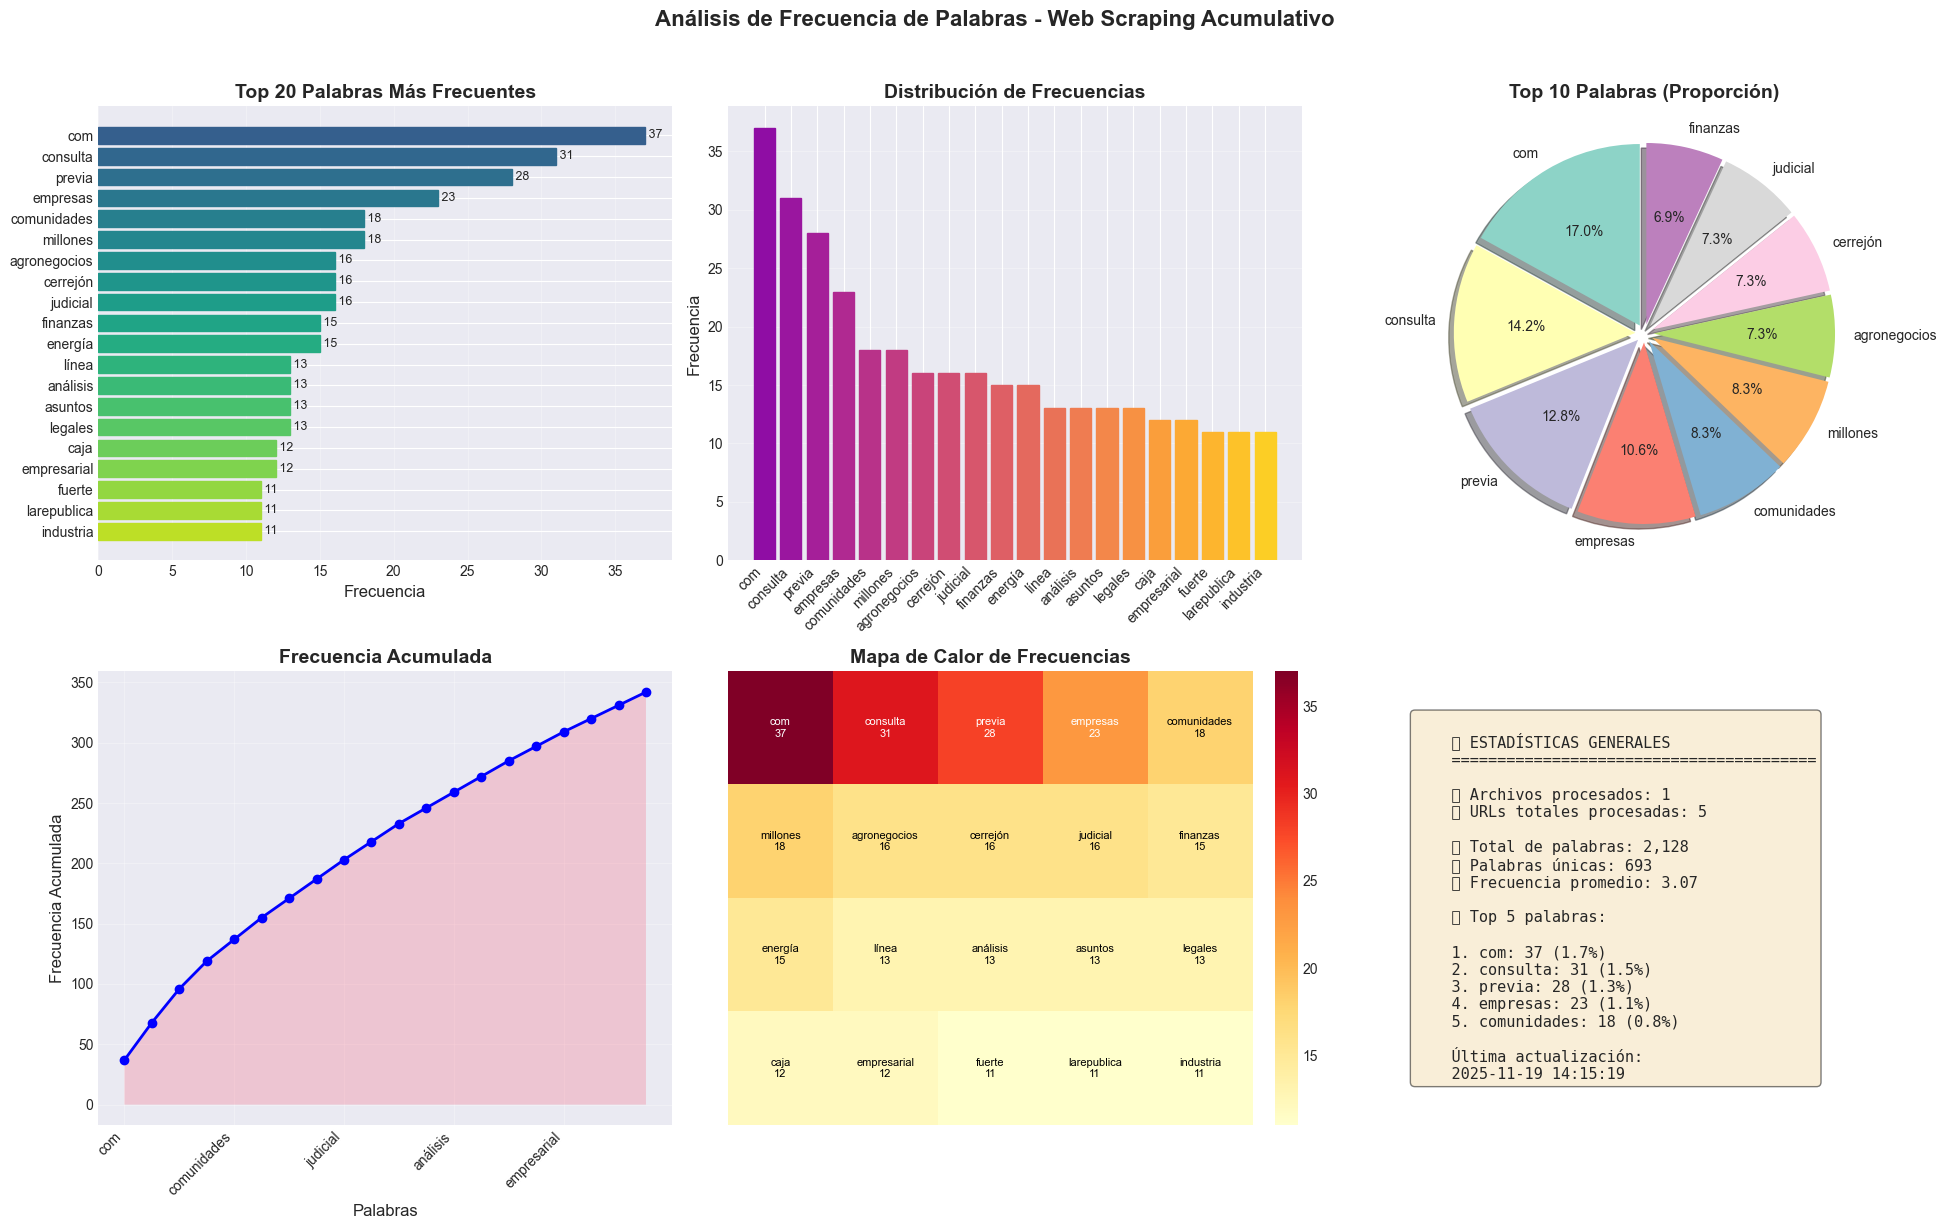


✅ Visualizaciones generadas y guardadas como 'analisis_palabras.png'


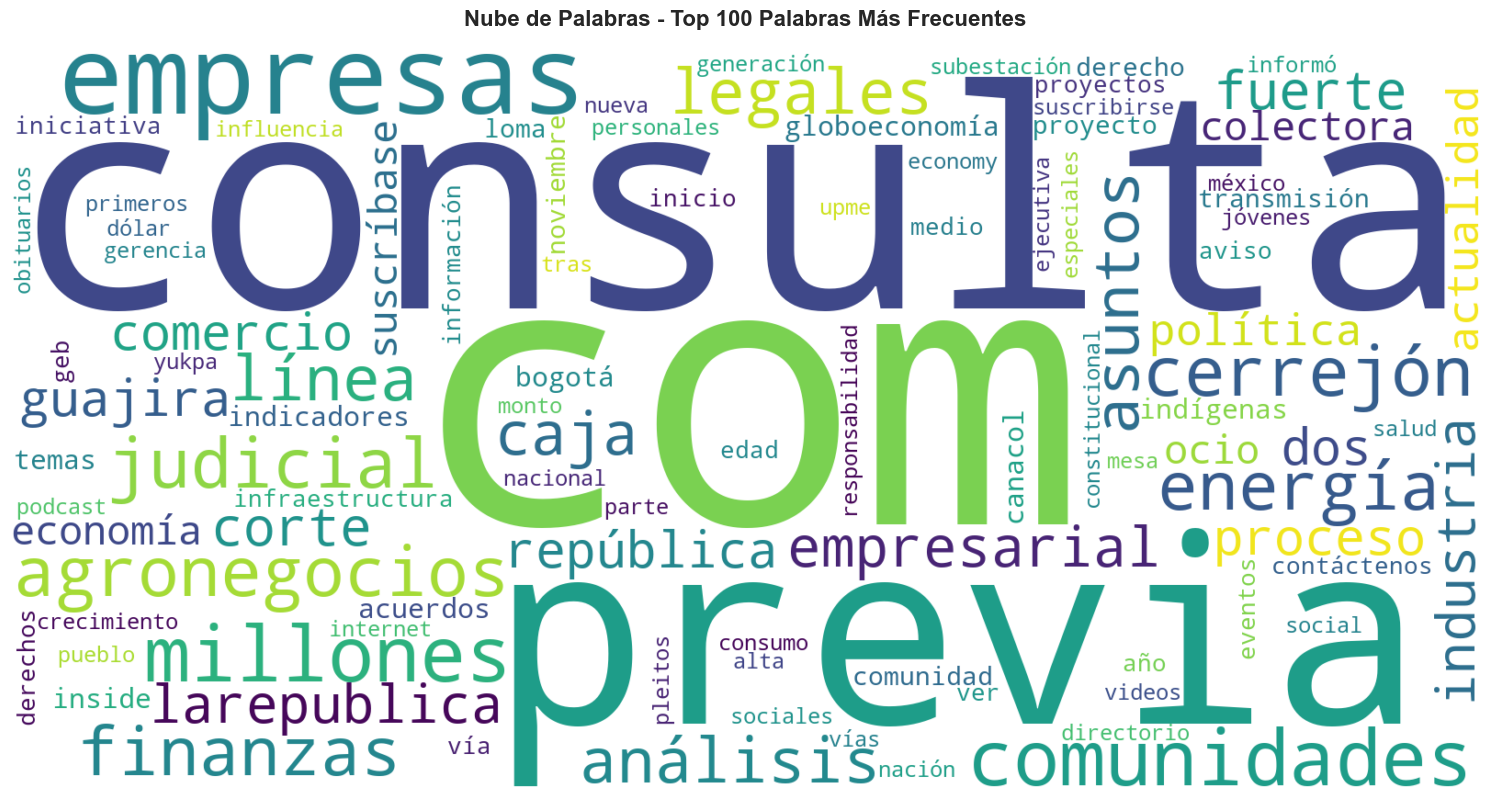


✅ Nube de palabras generada y guardada como 'nube_palabras.png'

📊 RESUMEN FINAL

✅ Proceso completado exitosamente

📈 Estadísticas acumuladas totales:
   • Archivos procesados: 1
   • URLs totales: 5
   • Palabras únicas: 693
   • Total de ocurrencias: 2128

🏆 Top 10 palabras más frecuentes:
    1. com                  - 37 ocurrencias
    2. consulta             - 31 ocurrencias
    3. previa               - 28 ocurrencias
    4. empresas             - 23 ocurrencias
    5. comunidades          - 18 ocurrencias
    6. millones             - 18 ocurrencias
    7. agronegocios         - 16 ocurrencias
    8. cerrejón             - 16 ocurrencias
    9. judicial             - 16 ocurrencias
   10. finanzas             - 15 ocurrencias


In [6]:
# Ejecutar el scraping
scraper = ejecutar_scraping()

## 8. Funciones Adicionales de Análisis

In [7]:
def buscar_palabra(scraper, palabra):
    """
    Busca una palabra específica en los datos acumulados
    """
    palabra = palabra.lower()
    if palabra in scraper.datos['palabras']:
        frecuencia = scraper.datos['palabras'][palabra]
        total = sum(scraper.datos['palabras'].values())
        porcentaje = (frecuencia / total) * 100
        
        # Encontrar ranking
        ranking = 1
        for p, f in scraper.datos['palabras'].items():
            if f > frecuencia:
                ranking += 1
        
        print(f"\n📊 Información de '{palabra}':")
        print(f"   • Frecuencia: {frecuencia:,}")
        print(f"   • Porcentaje del total: {porcentaje:.3f}%")
        print(f"   • Ranking: #{ranking} de {len(scraper.datos['palabras'])} palabras")
    else:
        print(f"\n❌ La palabra '{palabra}' no se encontró en los datos.")

def exportar_datos_csv(scraper, nombre_archivo='datos_palabras.csv'):
    """
    Exporta los datos a un archivo CSV
    """
    if not scraper.datos['palabras']:
        print("❌ No hay datos para exportar.")
        return
    
    # Crear DataFrame
    palabras_ordenadas = Counter(scraper.datos['palabras']).most_common()
    df = pd.DataFrame(palabras_ordenadas, columns=['Palabra', 'Frecuencia'])
    
    # Agregar columnas adicionales
    total = df['Frecuencia'].sum()
    df['Porcentaje'] = (df['Frecuencia'] / total * 100).round(3)
    df['Ranking'] = range(1, len(df) + 1)
    
    # Guardar CSV
    df.to_csv(nombre_archivo, index=False, encoding='utf-8')
    print(f"\n✅ Datos exportados a '{nombre_archivo}'")
    print(f"   • Total de palabras: {len(df)}")
    print(f"   • Total de ocurrencias: {total:,}")
    
    return df

def limpiar_datos_acumulados(scraper):
    """
    Limpia todos los datos acumulados (usar con precaución)
    """
    confirmacion = input("\n⚠️  ¿Está seguro que desea limpiar TODOS los datos acumulados? (si/no): ")
    
    if confirmacion.lower() == 'si':
        scraper.datos = {'palabras': {}, 'archivos_procesados': [], 'urls_procesadas': []}
        scraper.guardar_datos()
        print("\n✅ Datos limpiados exitosamente.")
    else:
        print("\n❌ Operación cancelada.")

## 9. Ejemplos de Uso de Funciones Adicionales

Descomenta y ejecuta las funciones que necesites:

In [8]:
# Buscar una palabra específica
# buscar_palabra(scraper, "energía")

# Exportar datos a CSV
# df_exportado = exportar_datos_csv(scraper)

# Limpiar todos los datos (CUIDADO: esto borrará todo el progreso)
# limpiar_datos_acumulados(scraper)

# Ver archivos procesados
# print("Archivos procesados:", scraper.datos['archivos_procesados'])

# Ver cantidad de URLs procesadas
# print(f"Total URLs procesadas: {len(scraper.datos['urls_procesadas'])}")

## 📝 Notas de Uso

### Cómo usar este notebook:

1. **Primera vez**: Ejecuta todas las celdas en orden
2. **Archivos de URLs**: Crea archivos .txt con una URL por línea
3. **Procesamiento acumulativo**: Cada vez que proceses un nuevo archivo, los datos se sumarán a los anteriores
4. **Persistencia**: Los datos se guardan en `datos_scraping.json`
5. **Visualizaciones**: Se generan automáticamente después de cada procesamiento

### Características principales:

- ✅ **Acumulativo**: Mantiene el progreso de sesiones anteriores
- ✅ **Evita duplicados**: No reprocesa URLs ya analizadas
- ✅ **Filtrado inteligente**: Excluye palabras vacías en español
- ✅ **Múltiples visualizaciones**: Gráficos de barras, pastel, nube de palabras, etc.
- ✅ **Exportación**: Puedes exportar los datos a CSV
- ✅ **Búsqueda**: Busca palabras específicas y obtén estadísticas

### Archivos generados:

- `datos_scraping.json`: Base de datos con todos los datos acumulados
- `analisis_palabras.png`: Visualizaciones múltiples
- `nube_palabras.png`: Nube de palabras
- `datos_palabras.csv`: Exportación de datos (opcional)